# MLP and CNN model for MNIST dataset (Keras with TensorFlow backend)

Based on the tutorial: [Handwritten Digit Recognition using Convolutional Neural Networks in Python with Keras](https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/)

## Script parameters

*   `MODEL_TYPE` - which model to build: `'MLP'` or `'CNN'`?
*   `EXAMPLES_COUNT` - how many examples to show from the training set
*   `SEED` - seed value for repeatable computation

In [1]:
MODEL_TYPE = 'CNN'  # MLP or CNN
EXAMPLES_COUNT = 64

SEED = 23

import numpy
numpy.random.seed(SEED)

## Loading MNIST dataset

In [2]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


## Plot some examples from the training set

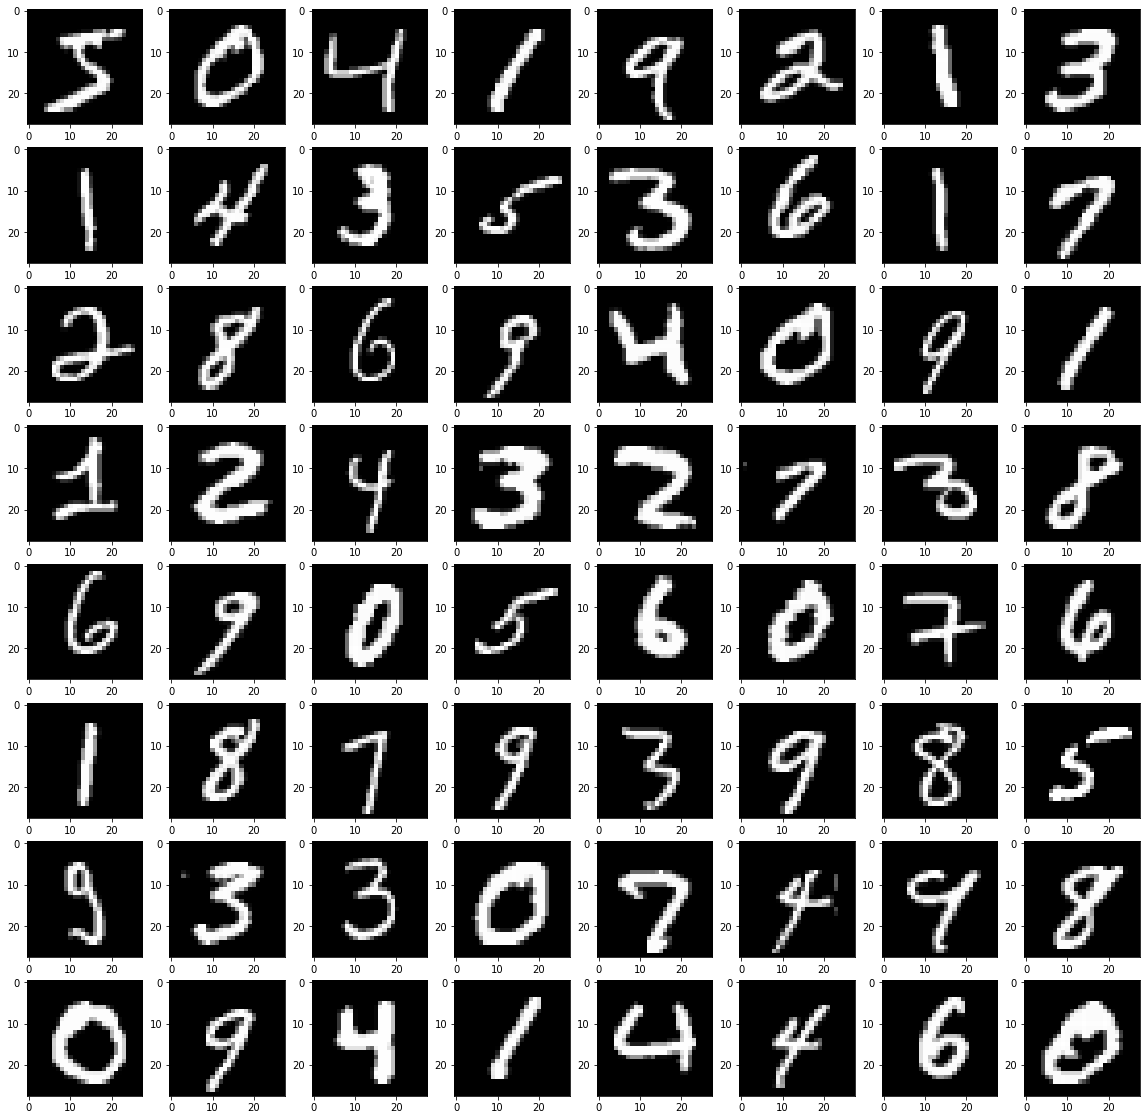

In [3]:
import math
import matplotlib.pyplot as plt

if EXAMPLES_COUNT > 0:
    plt.figure(figsize=(20, 20))
    for i in range(EXAMPLES_COUNT):
        sqrt_root = math.ceil(math.sqrt(EXAMPLES_COUNT))
        plt.subplot(sqrt_root, sqrt_root, i+1)
        plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.show()

## Scalling dataset values to \[0, 1\]

Scaling all the pixel values from \[0, 255\] (gray scale images) to \[0, 1\].

We cannot use `MinMaxScaler()` from `sklearn.preprocessing` because of the shape of the input data (2D images).
Instead dividing by the maximum value 255.

In [4]:
#from sklearn.preprocessing import MinMaxScaler
#x_train = MinMaxScaler().fit_transform(x_train)
#x_test = MinMaxScaler().fit_transform(x_test)
# => ValueError: Found array with dim 4. MinMaxScaler expected <= 2.

x_train = x_train / 255
x_test = x_test / 255

print("min: %f" % x_train[0].min(), "\nmax: %f" % x_train[0].max())  # Check values for the first image from the training set

min: 0.000000 
max: 1.000000


## Reshape input data

Flat vectors for MLP or 2D images for CNN (channels last)

*   `x_train.shape[0]` - number of images in training set
*   `x_train.shape[1]` and `x_train.shape[2]` - number of pixels in each image (28x28)

MLP: images 28x28 => 784 vector

CNN: reshape to be: \[samples\]\[height\]\[width\]\[pixels\]\
Pixels (channels) must be at the end, otherwise => Invalid argument: Conv2DCustomBackpropFilterOp only supports NHWC\
See: https://stackoverflow.com/questions/58896925/is-it-true-that-conv2dcustombackpropinputop-only-supports-nhwc

In [5]:
import sys

if MODEL_TYPE == 'MLP':    # 2D images to flat vectors: 28x28 => 784
    pixel_count = x_train.shape[1] * x_train.shape[2]    # x_train.shape[0] - number of images
    x_train = x_train.reshape(x_train.shape[0], pixel_count).astype('float32')
    x_test = x_test.reshape(x_test.shape[0], pixel_count).astype('float32')

elif MODEL_TYPE == 'CNN':    # reshape to be [samples][height][width][pixels]
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
    x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')

else:
    print("Wrong MODEL_TYPE! Please use 'MLP' or 'CNN' value.\n")
    sys.exit()

print("Shape of x_train: ", x_train.shape)
print("Shape of x_test: ", x_test.shape)

Shape of x_train:  (60000, 28, 28, 1)
Shape of x_test:  (10000, 28, 28, 1)


## One-hot encoding for softmax

In [6]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

class_count = y_train.shape[1]
print('Number of classes: %d' % class_count)

Number of classes: 10


## Create MLP or CNN model (as Keras Sequential)

MLP model:

1.   Hidden [`Dense()`](https://keras.io/layers/core/#dense) layer:
    *   number of hidden neurons equal to number of pixels in an image (the same size as input layer)
    *   `kernel_initializer='normal'` - initial weights from normal distribution: [Initializers - Keras Documentation](https://keras.io/initializers/)
    *    ReLU activation

2.   Output [`Dense()`](https://keras.io/layers/core/#dense) layer:
    *   initial weigths from normal distribution
    *   softmax activation


CNN model:

1.   Convolutional layer parameters:
    *   [`Conv2D()`](https://keras.io/layers/convolutional/#conv2d) - 2D convolution
    *   32 output filters in the convolution
    *   (5, 5) kernel size i.e. the height and width of the 2D convolution window
    *   `data_format='channels_last'` - corresponds to inputs with shape (batch, height, width, channels)\
    (same here: channels must be at the end)

2.   Pooling parameters:
    *   [`MaxPooling2D()`](https://keras.io/layers/pooling/#maxpooling2d) - max pooling operation in 2D
    *   (2, 2) pool size (the value of 2 would give the same effect)
    
3.   [`Dropout()`](https://keras.io/layers/core/#dropout) layer with 0.2 rate - randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting.

4.   [`Flatten()`](https://keras.io/layers/core/#flatten) layer - flattens the input.

5.   Hidden [`Dense()`](https://keras.io/layers/core/#dense) layer - provides bridge between CNN and MLP part of the network:
    *   128 neurons
    *   ReLU activation

6.   Output [`Dense()`](https://keras.io/layers/core/#dense) layer:
    *   10 output neurons
    *   softmax activation

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D

model = Sequential()

if MODEL_TYPE == 'MLP':
    model.add(Dense(pixel_count, input_dim=pixel_count, kernel_initializer='normal', activation='relu'))
    model.add(Dense(class_count, kernel_initializer='normal', activation='softmax'))

elif MODEL_TYPE == 'CNN':
    model.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1), data_format='channels_last', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.2, seed=SEED))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(class_count, activation='softmax'))

else:
    print("Wrong MODEL_TYPE value! Please use 'MLP' or 'CNN'.\n")
    sys.exit()

## Compile model and evaluate accuracy on the testing set

The [`model.fit()`](https://keras.io/models/sequential/#fit) function has two parameter options that can provide a validation set for the model training process, e.g.:

*   `validation_split=0.1` - use the last 10% of a training set to validate results on training,
*   `validation_data=(x_val, y_val)` - use `x_val` and `y_val` sets to validate training.

Validation set is used only to validate results in training. It is not used as a training set.

**Important: Don't use a testing set as a validation set in the training process!** E.g.:

`model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=200, verbose=2)`

Such training is *cheating* because a model will see test examples already in the training process!

In [8]:
EPOCHS = 10
BATCH_SIZE = 200
VERBOSE = 2

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=VERBOSE)
#model.fit(x_train, y_train, validation_split=0.1, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=VERBOSE)
# Don't cheat: model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=VERBOSE)

scores = model.evaluate(x_test, y_test, verbose=0)
print("\n%s accuracy: %.2f%%" % (MODEL_TYPE, scores[1] * 100))

Epoch 1/10
300/300 - 47s - loss: 0.2324 - accuracy: 0.9337
Epoch 2/10
300/300 - 30s - loss: 0.0689 - accuracy: 0.9793
Epoch 3/10
300/300 - 30s - loss: 0.0478 - accuracy: 0.9855
Epoch 4/10
300/300 - 29s - loss: 0.0378 - accuracy: 0.9885
Epoch 5/10
300/300 - 31s - loss: 0.0310 - accuracy: 0.9904
Epoch 6/10
300/300 - 32s - loss: 0.0251 - accuracy: 0.9922
Epoch 7/10
300/300 - 31s - loss: 0.0220 - accuracy: 0.9927
Epoch 8/10
300/300 - 30s - loss: 0.0180 - accuracy: 0.9944
Epoch 9/10
300/300 - 32s - loss: 0.0157 - accuracy: 0.9947
Epoch 10/10
300/300 - 31s - loss: 0.0132 - accuracy: 0.9960

CNN accuracy: 99.03%


## Make prediction on testing set and compute confusion matrix

Confusion matrix returned from [`confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) function in `sklearn.metrics` module has true values as rows and predicted as columns. This is not a standard convention for axes in confusion matrix: [Wikipedia entry for the Confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).

In [9]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(x_test, batch_size=100)
cnf_matrix = confusion_matrix(numpy.argmax(y_test, axis=1), numpy.argmax(y_pred, axis=1))    # compute confusion matrix after decoding from one-hot (it doesn't work on one-hot vectors!)
print(cnf_matrix.transpose())    # confusion_matrix() returns matrix with true values as rows, predicted as columns => swap it for print

[[ 977    0    0    0    0    2    6    0    4    1]
 [   0 1132    1    0    0    0    2    1    1    2]
 [   1    1 1025    4    0    0    0    5    3    2]
 [   0    0    0  996    0    4    0    0    0    0]
 [   0    0    1    0  973    0    2    0    0    4]
 [   0    0    0    7    0  884    3    0    0    3]
 [   0    1    0    0    1    1  944    0    0    0]
 [   1    1    4    0    0    0    0 1017    2    2]
 [   1    0    1    2    1    0    1    1  960    0]
 [   0    0    0    1    7    1    0    4    4  995]]


## Plot confusion matrix

We are using here [pretty-print-confusion-matrix](https://github.com/wcipriano/pretty-print-confusion-matrix) module created by [Wagner Cipriano](https://github.com/wcipriano) with some modifications of depracted features.

Direct GitHub link to the file: https://github.com/wcipriano/pretty-print-confusion-matrix/blob/master/confusion_matrix_pretty_print.py

The module plot a confusion matrix with seaborn and matplotlib.

There are two functions to use:
*   `pretty_plot_confusion_matrix()` - plot confusion matrix from an already computed matrix,
*   `plot_confusion_matrix_from_data()` - computes a confusion matrix first and then plot it.

Default parameters:
*   `annot=True` (print text in each cell)
*   `cmap='Oranges'`
*   `fmt='.2f'`
*   `fz=11` (font size)
*   `lw=0.5` (line width)
*   `cbar=False`
*   `figsize=[8,8]` (figure size)
*   `show_null_values=0`
*   `pred_val_axis='y'` (where to show the prediction values: x or y axis?)

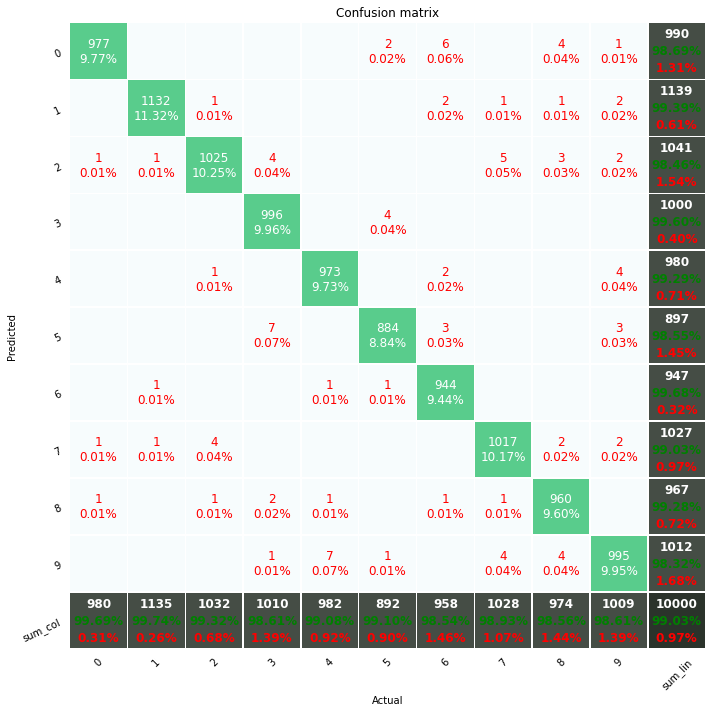

In [10]:
from pandas import DataFrame
from confusion_matrix_pretty_print import pretty_plot_confusion_matrix

df_cm = DataFrame(cnf_matrix, index=range(class_count), columns=range(class_count))
pretty_plot_confusion_matrix(df_cm, cmap='BuPu', figsize=(10, 10), fz=12)